# TMVA Classification 

This notebook is a basic example for training and testing LSTM model with TMVA and TMVA-Keras.

## Declare Factory class

In [14]:
import ROOT
from ROOT import TMVA
from subprocess import call
import os 

In [15]:
ROOT.TMVA.Tools.Instance()
TMVA.PyMethodBase.PyInitialize()

## For PYMVA methods
TMVA.PyMethodBase.PyInitialize();


outputFile = ROOT.TFile.Open("LSTM_ClassificationOutput.root", "RECREATE")

factory = ROOT.TMVA.Factory("TMVA_LSTM_Classification", outputFile,
                      "!V:ROC:Silent:Color:!DrawProgressBar:AnalysisType=Classification" )

## Declare DataLoader(s)

Next we get the data and declare the DataLoader class.

In this case the input data consists of an image of 32x32 pixels. Each ROOT TTree contains a single branch containg a vector of size 1024 denoting the image pixels.

In [16]:
# Load data
inputFileName = "sample_timedata_t10_d30.root"

if not os.path.isfile(inputFileName):
    call(['curl', '-o', inputFileName, 'https://cernbox.cern.ch/index.php/s/Pc8SBmHfvU1X0mb/download'])

In [17]:
inputFile = ROOT.TFile.Open( inputFileName )

# retrieve input trees
signalTree     = inputFile.Get("sgn")
backgroundTree = inputFile.Get("bkg")

signalTree.Print()

******************************************************************************
*Tree    :sgn       : sgn                                                    *
*Entries :    10000 : Total =        13449901 bytes  File  Size =   11259262 *
*        :          : Tree compression factor =   1.19                       *
******************************************************************************
*Br    0 :vars_time0 : vector<float>                                         *
*Entries :    10000 : Total  Size=    1344905 bytes  File Size  =    1124641 *
*Baskets :       44 : Basket Size=      32000 bytes  Compression=   1.19     *
*............................................................................*
*Br    1 :vars_time1 : vector<float>                                         *
*Entries :    10000 : Total  Size=    1344905 bytes  File Size  =    1124831 *
*Baskets :       44 : Basket Size=      32000 bytes  Compression=   1.19     *
*...................................................

In [18]:
dataloader = TMVA.DataLoader('dataset')

### Adding the trees
dataloader.AddSignalTree(signalTree, 1.0)
dataloader.AddBackgroundTree(backgroundTree, 1.0)

# Add variables
# Keras LSTM expects input of shape (None, timesteps, input_feat_dim)
timesteps = 10
feat_dim = 30
for t in range(timesteps):
    for i in range(feat_dim):
        varName = "var_{} := vars_time{}[{}]".format(t * feat_dim + i, t, i)
        dataloader.AddVariable(varName, 'F')
        
dataloader.PrepareTrainingAndTestTree( ROOT.TCut(''), ROOT.TCut(''),
                                  "nTrain_Signal=8000:nTrain_Background=8000:SplitMode=Random:"
                                   "NormMode=NumEvents:!V" )

create data set info dataset


# Booking Methods

Here we book the TMVA and TMVA-Keras methods.

### Book LSTM Network in TMVA

In [19]:
# #input layout 
# inputLayoutString = "InputLayout=10|1|30"
                                                                           
# ## Batch Layout                                                                                                                                     
# batchLayoutString = "BatchLayout=67|1|300"
                                                   
# layoutString = ("Layout=RESHAPE|10|1|30,RNN|95|30|10,RESHAPE|FLAT,DENSE|64|TANH,DENSE|1|TANH")

# ##Training strategies.                                                                                                                          
# training1 = ("LearningRate=0.0003,Momentum=0.9,Repetitions=1,"
#                      "ConvergenceSteps=10,BatchSize=67,TestRepetitions=1,"
#                      "MaxEpochs=1,WeightDecay=1e-4,Regularization=None,"
#                      "Optimizer=SGD,DropConfig=0.0+0.0+0.0+0.0")
 
# trainingStrategyString = "TrainingStrategy=" + training1
    
# ## General Options.                                                                                                                              
# rnnOptions = ("!H:V:ErrorStrategy=CROSSENTROPY:VarTransform=None:"
#                        "WeightInitialization=XAVIERUNIFORM")

# # rnnOptions +=  ":" + inputLayoutString
# rnnOptions +=  ":" + batchLayoutString
# rnnOptions +=  ":" + layoutString
# rnnOptions +=  ":" + trainingStrategyString
# rnnOptions +=  ":Architecture=CPU"

# ##book CNN
# factory.BookMethod(dataloader, TMVA.Types.kDL, "DL_RNN", rnnOptions)

### Book LSTM Network in Keras

In [20]:
## to use tensorflow backend
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

In [21]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Reshape
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.optimizers import SGD

In [22]:
# Generate model
hidden_dim = 256
batch_size = 64
epochs = 6

# Define model
model = Sequential()
model.add(Reshape((timesteps, feat_dim), input_shape=(timesteps * feat_dim,)))
model.add(Bidirectional(LSTM(hidden_dim, return_sequences=True)))
model.add(Bidirectional(LSTM(hidden_dim)))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

# Set loss and optimizer
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

# model.compile(loss='categorical_crossentropy',
#               optimizer=SGD(lr=0.001, decay=1e-6, momentum=0.9),
#               metrics=['accuracy'])

# Store model to file
model.save('model_lstm.h5')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 10, 30)            0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 10, 512)           587776    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 512)               1574912   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1026      
Total params: 2,163,714
Trainable params: 2,163,714
Non-trainable params: 0
_________________________________________________________________


In [23]:
# Book method
factory.BookMethod(dataloader, TMVA.Types.kPyKeras, 'PyKeras',
                   'H:!V:VarTransform=None:FilenameModel=model_lstm.h5:'
                   'FileNameTrainedModel=trained_model_lstm.h5:NumEpochs={}:BatchSize={}'.format(epochs, batch_size))

## Train Methods

In [24]:
factory.TrainAllMethods()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 10, 30)            0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 10, 512)           587776    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 512)               1574912   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1026      
Total params: 2,163,714
Trainable params: 2,163,714
Non-trainable params: 0
_________________________________________________________________
Train on 12800 samples, validate on 3200 samples
Epoch 1/6
12800/12800 [==============================] - 56s 

## Test and Evaluate Methods

In [25]:
factory.TestAllMethods()

In [26]:
factory.EvaluateAllMethods()

                         : 
                         : Evaluation results ranked by best signal efficiency and purity (area)
                         : -------------------------------------------------------------------------------------------------------------------
                         : DataSet       MVA                       
                         : Name:         Method:          ROC-integ
                         : dataset       PyKeras        : 0.927
                         : -------------------------------------------------------------------------------------------------------------------
                         : 
                         : Testing efficiency compared to training efficiency (overtraining check)
                         : -------------------------------------------------------------------------------------------------------------------
                         : DataSet              MVA              Signal efficiency: from test sample (from training sam

## Plot ROC Curve

We plot here the produce ROC curve obtained on evaluating the methods on the test data set

In [27]:
# //We enable JavaScript visualisation for the plots
# %jsroot on

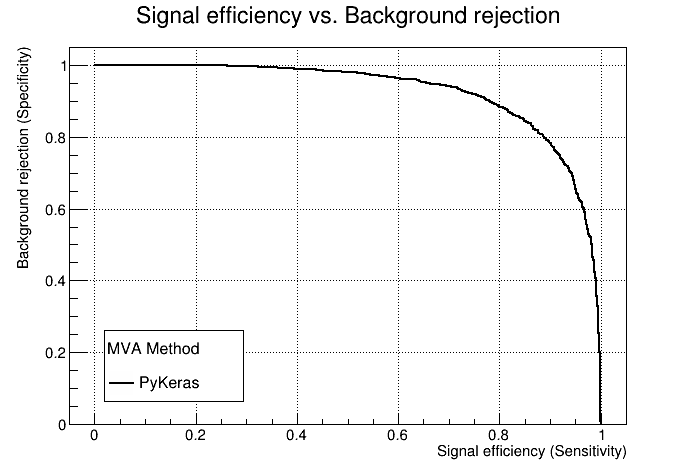

In [28]:
c1 = factory.GetROCCurve(dataloader);
c1.Draw();

####  Close outputfile to save all output information (evaluation result of methods)

In [29]:
outputFile.Close();